## Data loading for default of credit card clients dataset

To use the data, simply load the pickle file

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/train_test_split.pkl", "br") as fh:
    data = pickle.load(fh)
train_data = data[0]
test_data = data[1]

train_x = train_data[:,:23]
train_y = train_data[:,23] # labels are either 0 or 1
test_x = test_data[:,:23]
test_y = test_data[:,23] # labels are either 0 or 1

In [6]:
train_x.shape, train_y.shape

((20000, 23), (20000,))

Preprocessing

In [58]:
import numpy as np

# Normalize M so that sum of absolute values in each row is <= 1
M = np.hstack([train_x, np.ones((train_x.shape[0], 1))])
M = M / np.sum(np.abs(M), axis=1)[:, np.newaxis]

In [48]:
M[:23]

array([[0.14654591283449103, 7.327295641724553e-06,
        7.327295641724553e-06, 1.4654591283449105e-05,
        0.0002418007561769102, 7.327295641724553e-06,
        1.4654591283449105e-05, 1.4654591283449105e-05,
        1.4654591283449105e-05, 1.4654591283449105e-05,
        1.4654591283449105e-05, 0.1316788299774319, 0.12748761687036547,
        0.13963627304434478, 0.13521058647674317, 0.14475072540226852,
        0.14132887833758317, 0.0, 0.01655968815029749, 0.0,
        0.011723673026759283, 0.0, 0.004718778393270611,
        7.327295641724553e-06],
       [0.1450126523539179, 1.4501265235391788e-05,
        1.4501265235391788e-05, 1.4501265235391788e-05,
        0.0002537721416193563, 0.0, 0.0, 1.4501265235391788e-05, 0.0,
        0.0, 0.0, 0.11983845590527774, 0.14027798925456247,
        0.13486176668914363, 0.13776201973622199, 0.13776201973622199,
        0.1450126523539179, 0.02465215090016604, 0.0,
        0.007250632617695894, 0.0, 0.007250632617695894, 0.0,
        7

Training Process

In [60]:
# Algorithm 1 Implementation
n, d = M.shape
n, d
max_pass = 300
epsilon = 1e-10

w = np.zeros(d)
p_t = np.ones(n)/n

train_errors = []
test_errors = []
training_losses = []

for t in range(max_pass):
    # Normalize p_t
    p_t = p_t / np.sum(p_t)

    # Compute epsilon_t and gamma_t
    M_p_t = M * p_t[:, np.newaxis]
    epsilon_t = np.sum(p_t[M @ w <= 0])
    gamma_t = 1 - epsilon_t
    gamma_t = np.clip(gamma_t, epsilon, 1 - epsilon)

    # Update weights
    beta_t = 0.5 * np.log((1 + gamma_t) / (1 - gamma_t))
    # print(type(beta_t), beta_t)
    w += beta_t
    # print(type(-M @ (np.ones(d) * beta_t)), -M @ (np.ones(d) * beta_t))
    tmp_M = (-M @ (np.ones(d) * beta_t)).astype(np.float64)
    # print(tmp_M)
    # print("Before:", w, p_t)
    p_t = p_t * np.exp(tmp_M)
    # print("After:", w, p_t)

    # Compute training loss and errors
    h_w = np.sign(train_x @ w[:-1] + w[-1])
    tmp_pred = (-train_y * (train_x @ w[:-1] + w[-1])).astype(np.float64)
    train_loss = np.mean(np.exp(tmp_pred))
    train_error = np.mean(train_y != h_w)

    h_w_test = np.sign(test_x @ w[:-1] + w[-1])
    test_error = np.mean(test_y != h_w_test)

    training_losses.append(train_loss)
    train_errors.append(train_error)
    test_errors.append(test_error)

    print(f"Iteration {t}: Training Loss: {train_loss}, Training Error: {train_error}, Test Error: {test_error}")

Iteration 0: Training Loss: 0.9999910084535409, Training Error: 0.78185, Test Error: 0.7727
Iteration 1: Training Loss: 0.78185, Training Error: 0.78185, Test Error: 0.7727
Iteration 2: Training Loss: 0.78185, Training Error: 0.78185, Test Error: 0.7727
Iteration 3: Training Loss: 0.78185, Training Error: 0.78185, Test Error: 0.7727
Iteration 4: Training Loss: 0.78185, Training Error: 0.78185, Test Error: 0.7727
Iteration 5: Training Loss: 0.78185, Training Error: 0.78185, Test Error: 0.7727
Iteration 6: Training Loss: 0.78185, Training Error: 0.78185, Test Error: 0.7727
Iteration 7: Training Loss: 0.78185, Training Error: 0.78185, Test Error: 0.7727
Iteration 8: Training Loss: 0.78185, Training Error: 0.78185, Test Error: 0.7727
Iteration 9: Training Loss: 0.78185, Training Error: 0.78185, Test Error: 0.7727
Iteration 10: Training Loss: 0.78185, Training Error: 0.78185, Test Error: 0.7727
Iteration 11: Training Loss: 0.78185, Training Error: 0.78185, Test Error: 0.7727
Iteration 12: T

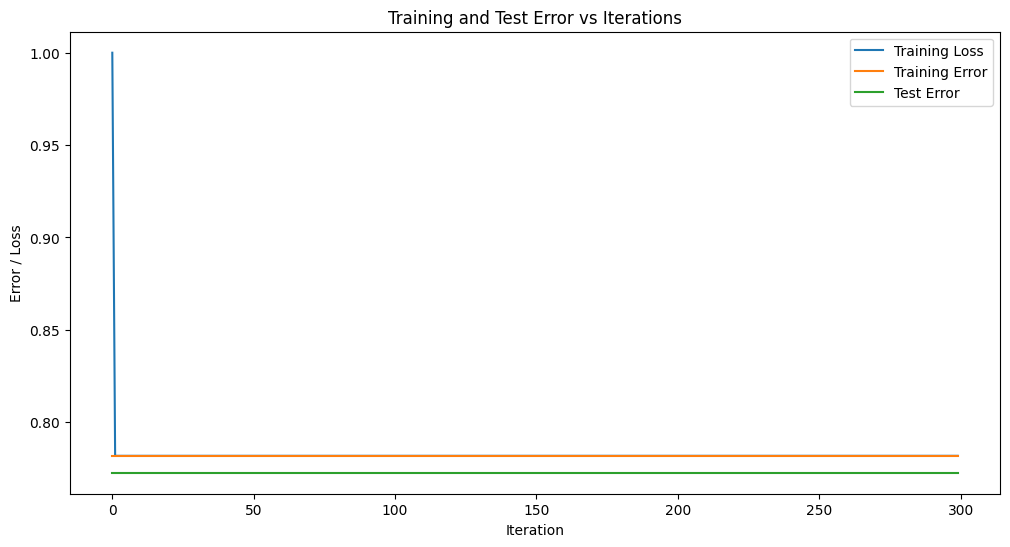

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(train_errors, label='Training Error')
plt.plot(test_errors, label='Test Error')
plt.xlabel('Iteration')
plt.ylabel('Error / Loss')
plt.legend()
plt.title('Training and Test Error vs Iterations')
plt.show()

In [66]:
n, d = M.shape
max_pass = 300

w = np.zeros(d)
p_t = np.ones(n) / n

train_errors = []
test_errors = []
training_losses = []

for t in range(max_pass):
    # Normalize p_t
    p_t = (p_t + epsilon) / np.sum(p_t + epsilon)

    # Compute epsilon_t and gamma_t for each feature
    epsilon_t_j = np.array([np.sum(p_t * (M[:, j] * train_y <= 0)) for j in range(d)])
    gamma_t_j = 1 - epsilon_t_j

    # Select j_t according to the given criterion
    j_t = np.argmax(np.abs(np.sqrt(epsilon_t_j) - np.sqrt(gamma_t_j)))

    # Set alpha_t to have 1 on the j_t-th entry and 0 everywhere else
    alpha_t = np.zeros(d)
    alpha_t[j_t] = 1

    # Compute epsilon_t and gamma_t for the selected feature
    epsilon_t = epsilon_t_j[j_t]
    gamma_t = gamma_t_j[j_t]
    gamma_t = np.clip(gamma_t, epsilon, 1 - epsilon)

    # Update weights
    beta_t = 0.5 * np.log((1 + gamma_t) / (1 - gamma_t))
    w[j_t] += beta_t

    # Update p_t
    p_t = p_t * np.exp((-beta_t * (M[:, j_t] * train_y)).astype(np.float64))

    # Compute training loss and errors
    h_w = np.sign(train_x @ w[:-1] + w[-1])
    train_loss = np.mean(np.exp((-train_y * (train_x @ w[:-1] + w[-1])).astype(np.float64)))
    train_error = np.mean(train_y != h_w)

    h_w_test = np.sign(test_x @ w[:-1] + w[-1])
    test_error = np.mean(test_y != h_w_test)

    training_losses.append(train_loss)
    train_errors.append(train_error)
    test_errors.append(test_error)

    print(f"Iteration {t}: Training Loss: {train_loss}, Training Error: {train_error}, Test Error: {test_error}")

Iteration 0: Training Loss: 0.9993535058289105, Training Error: 0.5063, Test Error: 0.5046
Iteration 1: Training Loss: 0.9999542479545377, Training Error: 0.5063, Test Error: 0.5046
Iteration 2: Training Loss: 1.001733874981751, Training Error: 0.5063, Test Error: 0.5046
Iteration 3: Training Loss: 1.0046527995891936, Training Error: 0.5063, Test Error: 0.5046
Iteration 4: Training Loss: 1.008694988046024, Training Error: 0.5063, Test Error: 0.5046
Iteration 5: Training Loss: 1.0138644088503876, Training Error: 0.5063, Test Error: 0.5046
Iteration 6: Training Loss: 1.020182678722815, Training Error: 0.5063, Test Error: 0.5046
Iteration 7: Training Loss: 1.0276875864557313, Training Error: 0.5063, Test Error: 0.5046
Iteration 8: Training Loss: 1.0364322741009768, Training Error: 0.5063, Test Error: 0.5046
Iteration 9: Training Loss: 1.046484924093432, Training Error: 0.5063, Test Error: 0.5046
Iteration 10: Training Loss: 1.0579288494101555, Training Error: 0.5063, Test Error: 0.5046
It

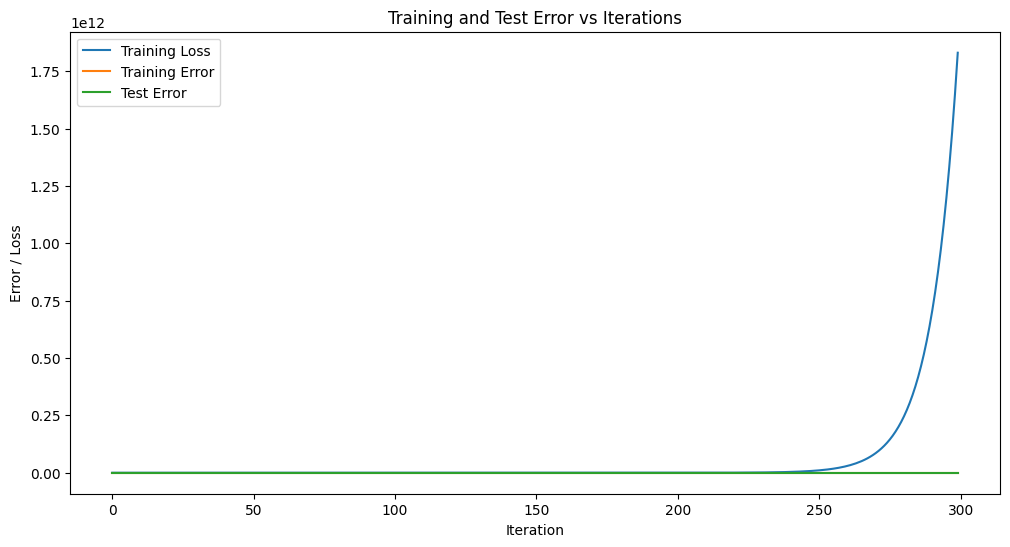

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(train_errors, label='Training Error')
plt.plot(test_errors, label='Test Error')
plt.xlabel('Iteration')
plt.ylabel('Error / Loss')
plt.legend()
plt.title('Training and Test Error vs Iterations')
plt.show()